# **Set Env**

In [28]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Promoter-Classification'
REPO_URL = "https://github.com/nmach22/Promoter-Classification.git"

# 1. Delete repo if it already exists (Ensure fresh code)
if os.path.exists(REPO_PATH):
    print(f"Deleting existing repository at {REPO_PATH}...")
    shutil.rmtree(REPO_PATH)

# 2. Clone repository
os.chdir('/content/drive/MyDrive')
print(f"Cloning repository to {REPO_PATH}...")
!git clone {REPO_URL}

# 3. Enter the repository
os.chdir(REPO_PATH)
print(f"Current working directory: {os.getcwd()}")

# 4. Add source code to Python path
sys.path.append(REPO_PATH)

# 5. Install requirements
!pip install -r requirements.txt
!pip install xgboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Deleting existing repository at /content/drive/MyDrive/Promoter-Classification...
Cloning repository to /content/drive/MyDrive/Promoter-Classification...
Cloning into 'Promoter-Classification'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 228 (delta 26), reused 27 (delta 11), pack-reused 177 (from 1)
Receiving objects: 100% (228/228), 8.24 MiB | 9.61 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Current working directory: /content/drive/MyDrive/Promoter-Classification
ERROR: Could not find a version that satisfies the requirement Bioxgboost (from versions: none)
ERROR: No matching distribution found for Bioxgboost


In [29]:
!pip install xgboost
!pip install Bio

# **Imports**

In [54]:
import sys
import os
import yaml
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, classification_report, roc_curve, auc
from Bio import SeqIO
import importlib

# Set ROOT_DIR to the current working directory (which is REPO_PATH set in previous cell)
ROOT_DIR = os.getcwd()
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

import utils.fasta_dataset as dataset_module
import utils.encoding_functions as encoding_module
import utils.data_split as splitter_module
import models.xgboost_model as xgboost_module

importlib.reload(encoding_module)
importlib.reload(xgboost_module)

from utils.fasta_dataset import FastaDataset
from utils.encoding_functions import one_hot_encode, flatten_one_hot_encode, kmer_encode
from utils.data_split import dataset_split
from models.xgboost_model import XGBoostPromoterModel

with open(f"{ROOT_DIR}/config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

print("Config loaded.")


Config loaded.


# **Feature Engineering**

XGBoost requires numerical input. We will use two types of features:
1. **Flattened One-Hot Encoding**: Preserves positional information (critical for promoter motifs like TATA box at specific locations).
2. **K-mer Counts**: Captures frequency of short subsequences (e.g., 3-mers).

In [55]:
# We use functions from utils.encoding_functions
# flatten_one_hot_encode(seq, max_seq_len)
# kmer_encode(seq, seq_len, k=3)

def combined_features(seq, max_seq_len, k=3):
    """
    Combines flattened one-hot and k-mer counts.
    """
    one_hot = flatten_one_hot_encode(seq, max_seq_len)
    # kmers = kmer_encode(seq, max_seq_len, k=k) # Uncomment to add k-mers
    # return np.concatenate([one_hot, kmers])
    return one_hot # Start with one-hot as primary feature


# **Read & Prepare Data**

In [64]:
# Select Dataset (e.g., E. coli)
dataset_key = 'mouse_tata' # Change this to 'human_tata', 'mouse_tata', etc.
data_config = config['data'][dataset_key]
prom_path = f"{ROOT_DIR}/{data_config['promoter_fasta']}"
non_prom_path = f"{ROOT_DIR}/{data_config['non_promoter_fasta']}"
seq_length = data_config['seq_len']

print(f"Using dataset: {data_config['name']}")
print(f"Promoter file: {prom_path}")
print(f"Non-promoter file: {non_prom_path}")

# Use FastaDataset
dataset = FastaDataset(
    prom_path,
    non_prom_path,
    seq_len=seq_length,
    encoding_func=lambda s, l: combined_features(s, l)
)

print(f"Total samples: {len(dataset)}")
print(f"Feature vector shape: {dataset[0][0].shape}")

Using dataset: Mouse TATA
Promoter file: /content/drive/MyDrive/Promoter-Classification/dataset/Mouse_tata.fa
Non-promoter file: /content/drive/MyDrive/Promoter-Classification/dataset/Mouse_non_tata.fa
Total samples: 17538
Feature vector shape: torch.Size([1004])


# **Dataset Visualization**

/tmp/ipython-input-2410761370.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['skyblue', 'salmon'])


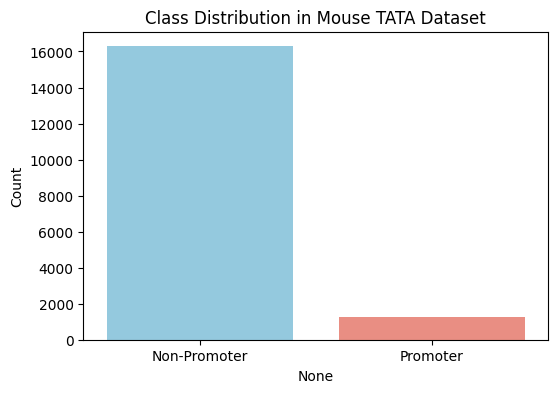

Class Distribution:
Non-Promoter    16283
Promoter         1255
Name: count, dtype: int64


In [65]:
labels = [dataset[i][1].item() for i in range(len(dataset))]
label_counts = pd.Series(labels).value_counts().sort_index()
label_counts.index = ['Non-Promoter', 'Promoter']

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['skyblue', 'salmon'])
plt.title(f'Class Distribution in {data_config["name"]} Dataset')
plt.ylabel('Count')
plt.show()

print("Class Distribution:")
print(label_counts)

# **Split Data**

In [67]:
train_subset, val_subset, test_subset = dataset_split(dataset)

def subset_to_numpy(subset):
    """
    Converts a PyTorch Subset to numpy arrays (X, y).
    """
    X = []
    y = []
    for i in range(len(subset)):
        sample_x, sample_y = subset[i]
        X.append(sample_x.numpy())
        y.append(sample_y.item())
    return np.array(X), np.array(y)

print("Converting datasets to numpy arrays for XGBoost...")
X_train, y_train = subset_to_numpy(train_subset)
X_val, y_val = subset_to_numpy(val_subset)
X_test, y_test = subset_to_numpy(test_subset)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Converting datasets to numpy arrays for XGBoost...
Train shape: (12276, 1004), (12276,)
Val shape: (2630, 1004), (2630,)
Test shape: (2632, 1004), (2632,)


# **Train XGBoost Model**

In [68]:
# Calculate scale_pos_weight to handle class imbalance
num_neg = len(y_train) - sum(y_train)
num_pos = sum(y_train)
scale_weight = num_neg / num_pos

print(f"Class Imbalance - Negatives: {num_neg}, Positives: {num_pos}")
print(f"Using scale_pos_weight: {scale_weight:.2f}")

# Initialize model with class weight
model = XGBoostPromoterModel(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_weight # Give more weight to promoters
)

# Train and capture logs
print("Training...")
evals_result = {}
model.model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

# Retrieve results manually if using wrapper or access underlying model
results = model.model.evals_result()


Class Imbalance - Negatives: 11398, Positives: 878
Using scale_pos_weight: 12.98
Training...
[0]	validation_0-logloss:0.65552	validation_1-logloss:0.65605
[50]	validation_0-logloss:0.15965	validation_1-logloss:0.18065
[100]	validation_0-logloss:0.08635	validation_1-logloss:0.12478
[150]	validation_0-logloss:0.04789	validation_1-logloss:0.10680
[200]	validation_0-logloss:0.02811	validation_1-logloss:0.09805
[250]	validation_0-logloss:0.01744	validation_1-logloss:0.09456
[300]	validation_0-logloss:0.01165	validation_1-logloss:0.09387
[350]	validation_0-logloss:0.00791	validation_1-logloss:0.09343
[400]	validation_0-logloss:0.00579	validation_1-logloss:0.09300
[424]	validation_0-logloss:0.00507	validation_1-logloss:0.09281


# **Training Curves**

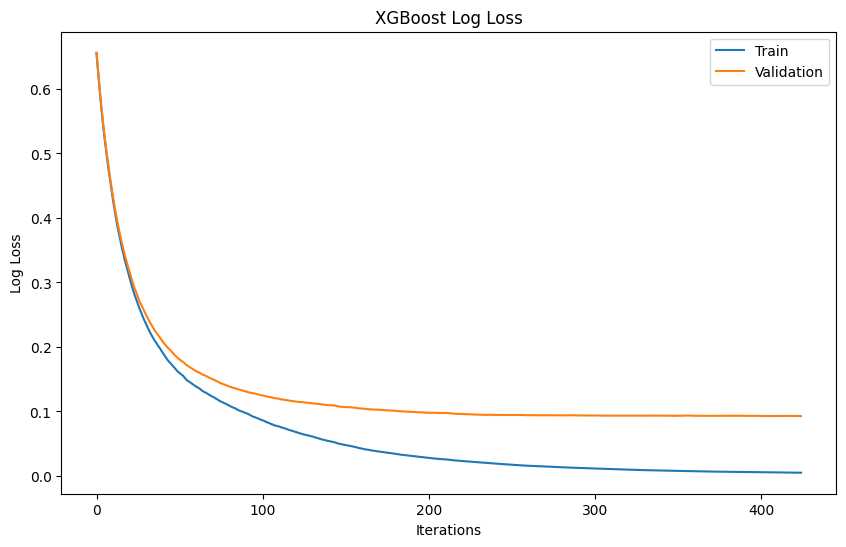

In [69]:
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Iterations')
plt.title('XGBoost Log Loss')
plt.show()

# **Evaluation**

Metrics from paper:
- **Sn (Sensitivity)**: Recall
- **Sp (Specificity)**: True Negative Rate
- **CC**: Matthews Correlation Coefficient


In [70]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    return {
        "Accuracy": accuracy,
        "Sensitivity (Sn)": sensitivity,
        "Specificity (Sp)": specificity,
        "CC (MCC)": mcc,
        "Confusion Matrix": cm
    }

# Try different thresholds
thresholds = [0.3, 0.4, 0.5]
for t in thresholds:
    print(f"\n--- Threshold: {t} ---")
    y_pred = model.predict(X_test, threshold=t)
    metrics = calculate_metrics(y_test, y_pred)
    for k, v in metrics.items():
        if k != "Confusion Matrix":
            print(f"{k}: {v:.4f}")

# Use best threshold for plots (e.g. 0.4)
best_threshold = 0.4
y_pred = model.predict(X_test, threshold=best_threshold)
y_prob = model.predict_proba(X_test)[:, 1]
metrics = calculate_metrics(y_test, y_pred)



--- Threshold: 0.3 ---
Accuracy: 0.9529
Sensitivity (Sn): 0.8783
Specificity (Sp): 0.9587
CC (MCC): 0.7157

--- Threshold: 0.4 ---
Accuracy: 0.9582
Sensitivity (Sn): 0.8413
Specificity (Sp): 0.9673
CC (MCC): 0.7265

--- Threshold: 0.5 ---
Accuracy: 0.9597
Sensitivity (Sn): 0.7884
Specificity (Sp): 0.9730
CC (MCC): 0.7177


# **Visualizations**

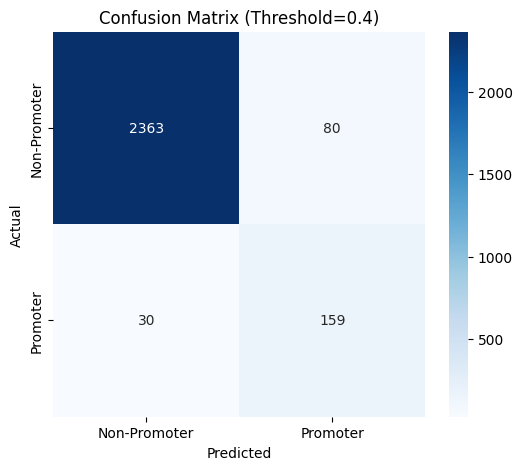

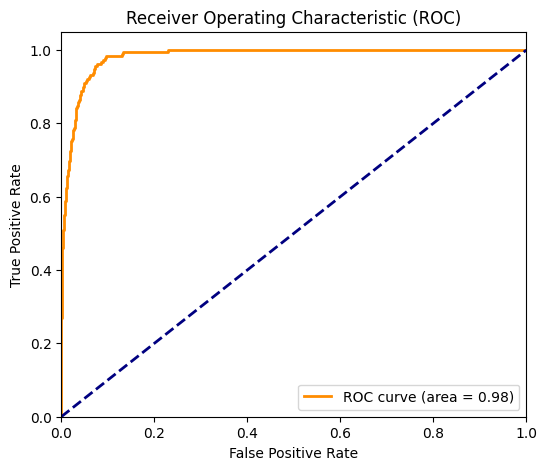

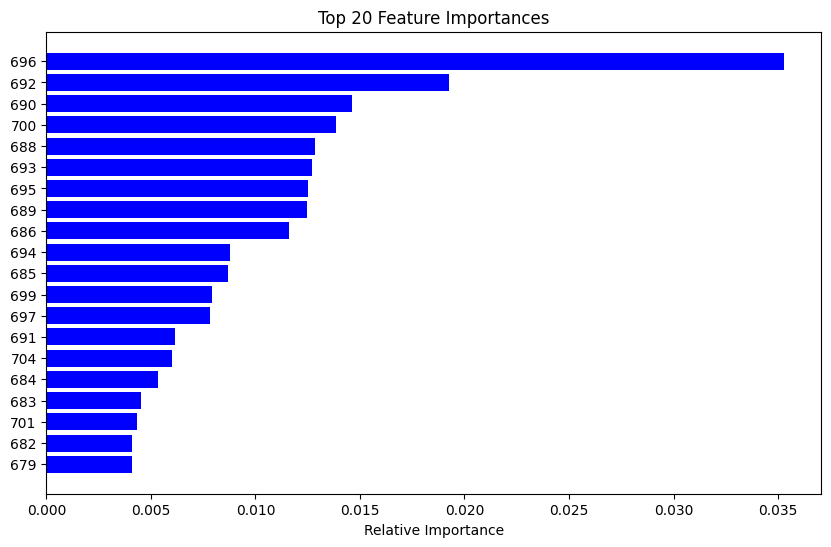

In [71]:
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
cm = metrics["Confusion Matrix"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Promoter', 'Promoter'], yticklabels=['Non-Promoter', 'Promoter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold={best_threshold})')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. Feature Importance (Top 20)
importance = model.model.feature_importances_
indices = np.argsort(importance)[-20:]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

# **Save Model**

In [63]:
import os

save_dir = f"{ROOT_DIR}/models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = f"{save_dir}/xgboost_model.json"
model.save_model(save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/Promoter-Classification/models//xgboost_model.json
